# Simulating SC/KA Lennard-Jones with rumdpy 

Features included:
- cooling ramp giving insight into phase behavior
- lin-saving of scalars ('energies') within blocks
- log2-saving of configurations within blocks
- on-the-fly 3D visualization

In [15]:
# Reproducing 'ATU' run in phd1:
#    LJ, N=864, rho=0.60, cooling from T=3.0 to 0.1 with dt=0.005, 
#    scalars: every 20'th step, trajectory: 194 log-blocks    
#
# Timestep:                                        200_000                2_000_000
# Rumd3  GTX TITAN,        4.5 TFlops, 288 GB/s, runtime: 56   sec        196   sec ( 121 conf_blocks * 285 Kb)       rumd_rdf: 11.8s, rumd_msd: 6s
# Rumd3  RTX 2080 Ti,     11.7 TFlops, 616 GB/s, runtime: 38.9 sec         77.8 sec ( 121 conf_blocks * 285 Kb)       rumd_rdf: 11.8s, rumd_msd: 6s
# rumdpy RTX 3070 Laptop, 11.4 TFlops, 448 GB/s, runtime: 10.0 sec (256k)  39.9 sec (1000 conf_blocks * 257/167z Kb)  on-the-fly     ~1s 

## Imports

In [1]:
import numpy as np
import numba
import math

# rumdpy
import rumdpy as rp

# IO
import pandas as pd
import pickle
import sys
import h5py

# Plotting and visualization
import matplotlib.pyplot as plt
#%matplotlib inline
#%matplotlib notebook
%matplotlib widget


## Generate configuration with a FCC lattice

In [22]:
include_KABLJ = True

c1 = rp.make_configuration_fcc(nx=6,  ny=6,  nz=6,  rho=0.60,  T=3.44)      # N = 4*6**3   =  864
#c1 = rp.make_configuration_fcc(nx=16,  ny=4,  nz=4,  rho=0.60,  T=3.44)    # N = 4*18*6*6 = 2592

if include_KABLJ:
    c1.ptype[::5] = 1 # 4:1 mixture

print(f'Number of particles: {c1.N}; Density: {c1.N/np.prod(c1.simbox.data):.3f}; B fraction: {np.mean(c1.ptype==1):.3f}')
c1.copy_to_device() 

# Get a 'compute-plan', i.e. parameters determining how simulations are performed on the GPU
# (to facilitate implementation of an auto-tuner, the choice of these parameters should be delayed to just before simulation)
compute_plan = rp.get_default_compute_plan(c1)
print('compute_plan:', compute_plan)

Number of particles: 864; Density: 0.600; B fraction: 0.200
compute_plan: {'pb': 8, 'tp': 16, 'skin': 0.5, 'UtilizeNIII': False, 'gridsync': True}


## Setup Lennard-Jones pair potential

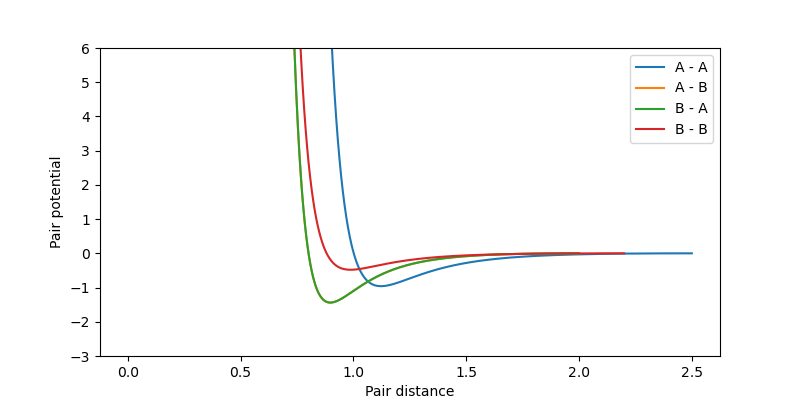

In [4]:
#potential_function = rp.apply_shifted_force_cutoff(rp.make_LJ_m_n(12,6))
potential_function = rp.apply_shifted_force_cutoff(rp.LJ_12_6)
sigma =   [[1.00, 0.80], # Setting up KABLJ. If all particles are type 0, 
           [0.80, 0.88]] # ... this reverts to single component LJ
epsilon = [[1.00, 1.50], 
           [1.50, 0.50]] 
cutoff = np.array(sigma)*2.5
params = rp.LJ_12_6_params_from_sigma_epsilon_cutoff(sigma, epsilon, cutoff)
LJ = rp.PairPotential(c1, potential_function, params=params, max_num_nbs=1000, compute_plan=compute_plan)
pairs = LJ.get_interactions(c1, exclusions=None, compute_plan=compute_plan, verbose=False)
LJ.plot(names=['A', 'B'])

In [24]:
c1.N = 500

864

In [26]:
np.prod(c1.simbox.data)

1440.0001

In [27]:
c1.simbox.data

array([11.292433, 11.292433, 11.292433], dtype=float32)

In [29]:
c1.simbox.data[1] *= 10
c1.simbox.data

array([  11.292433, 1129.2433  ,   11.292433], dtype=float32)

In [31]:
c1['r']

array([[-5.1756983, -5.1756983, -5.1756983],
       [-4.234662 , -4.234662 , -5.1756983],
       [-4.234662 , -5.1756983, -4.234662 ],
       ...,
       [ 5.1756983,  5.1756983,  4.234662 ],
       [ 5.1756983,  4.234662 ,  5.1756983],
       [ 4.234662 ,  5.1756983,  5.1756983]], dtype=float32)

## Setup output managers

In [5]:
# Should be more elegant - and more flexible (move to simulation class?)

steps_between_output = 16
output_calculator = rp.make_scalar_calculator(c1, steps_between_output, compute_plan)

conf_saver = rp.make_conf_saver(c1, compute_plan)

include_rdf = True
if include_rdf:
    num_bins = 500
    full_range=True
    gr_bins_zeros = np.zeros(num_bins, dtype=np.float64) # float64 good / necessary ?
    d_gr_bins = numba.cuda.to_device(gr_bins_zeros)
       
    rdf_calculator = rp.make_rdf_calculator(c1, pair_potential = LJ, compute_plan=compute_plan, full_range=full_range, verbose=True)  

## Setup integrator

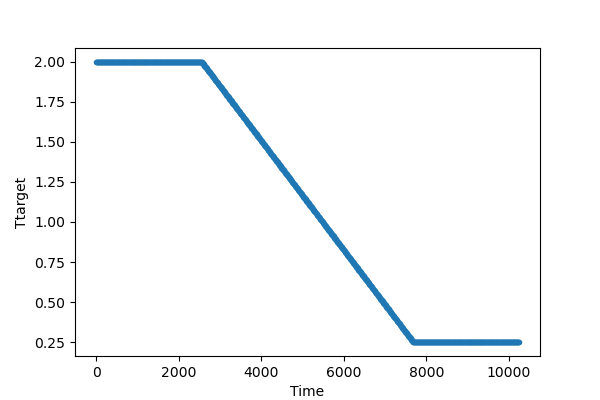

In [6]:
dt = 0.005 # timestep 
num_blocks = 1000         # Do simulation in this many 'blocks'
steps_per_block = 2*1024  # ... each of this many steps
running_time = dt*num_blocks*steps_per_block

Thigh = 2.00
Tlow  = 0.25
Ttarget_function = rp.make_function_ramp(value0=Thigh, x0=running_time*(1/4), value1=Tlow, x1=running_time*(3/4))

integrator = rp.integrators.nvt.setup_output(c1, pairs['interactions'], output_calculator, conf_saver, Ttarget_function, tau=0.2, dt=dt, compute_plan=compute_plan, verbose=False)

plt.figure(figsize=(6,4))
t = np.linspace(0,running_time,num_blocks)
plt.plot(t, numba.vectorize(Ttarget_function)(t), '.-')
plt.xlabel('Time')
plt.ylabel('Ttarget')
plt.show()

## Run simulation

In [7]:
sim = rp.simulation(c1, integrator, dt, pairs, num_blocks, steps_per_block, steps_between_output, include_rdf=False, storage='memory')

Configurations per block (log2-storing): 13
Storing results in memory. Expected footprint 257.08 MB.


Start by running only part of the simulation. Might be for testing/benchmark/equilibration:

In [8]:
for block in sim.run(num_blocks=100):
    if block%25==0:
        print(block, end=' ')
sim.print_summary()

0 25 50 75 
steps : 204800
nbflag :  [    0     0 22264]
time : 5.42588134765625 s
TPS :  37745.02000278073
Blocks/Frames per second :  18.430185548232778


In [9]:
for block in sim.run(num_blocks=100):
    if block%25==0:
        print(block, end=' ')
sim.print_summary()

0 25 50 75 
steps : 204800
nbflag :  [    0     0 44539]
time : 3.827570068359375 s
TPS :  53506.53190988719
Blocks/Frames per second :  26.126236284124605


The difference (~1.5 second) is the time taken on first run to do just-in-time (JIT) compilation to the GPU.

In [10]:
sim = rp.simulation(c1, integrator, dt, pairs, num_blocks, steps_per_block, steps_between_output, include_rdf=False, storage='hdf5', filename='output')

Configurations per block (log2-storing): 13
Saving results in hdf5 format. Filename: output.h5


In [11]:
for block in sim.run(num_blocks=100):
    if block%25==0:
        print(block, end=' ')
sim.print_summary()

0 25 50 75 
steps : 204800
nbflag :  [    0     0 66799]
time : 3.907586181640625 s
TPS :  52410.872206026026
Blocks/Frames per second :  25.591246194348646


## Run with 3D visualization

In [30]:
from rumdpy.visualization import k3d_Visualization # Requires the 'k3d' package

viz = k3d_Visualization(sim)
viz.display()
for block in sim.run(1000):
    viz.update(block, choice=0)
viz.display_player()
sim.print_summary()

Output()

KeyboardInterrupt: 

In [13]:
# Auto scale color-range using final configuration
viz.plt_fn_text.text = 'u'
attribute = c1.scalars[:,0]
print(np.mean(attribute), np.std(attribute), min(attribute), max(attribute))
viz.plt_points.attribute = attribute
viz.plt_points.color_range=[min(attribute), max(attribute)]

-6.2617626 1.3648973 -9.445502 -2.4172034


## Write results to disc.
- should be included in 'sim'
- file formats should be considered, parquet?, hdf5?

In [33]:
if type(sim.scalars_t) == list:
    sim.scalars_t = np.concatenate(sim.scalars_t)
if type(sim.simbox_data_list) == list:
    sim.simbox_data_list = np.concatenate(sim.simbox_data_list)
# Save data
df = pd.DataFrame(sim.scalars_t, columns=['u', 'w', 'lap', 'fsq', 'k'], dtype=np.float32)
df['t'] = np.array(np.arange(sim.scalars_t.shape[0])*dt*steps_between_output, dtype=np.float32)
df['vol'] = np.prod(sim.conf.simbox.data) # ASSUMED CONSTANT

df['Ttarget'] = numba.vectorize(Ttarget_function)(np.array(df['t']))
#if integrator=='NPT_Langevin':
#    df['Ptarget'] = numba.vectorize(P0)(np.array(df['t'])) 
df.to_csv('Data/LJ_scalars.csv', index=False)

!ls -lh Data/LJ_scalars.csv

-rw-rw-r-- 1 tbs tbs 9.2M Jan 24 18:21 Data/LJ_scalars.csv


In [34]:
if sim.include_rdf:
    if type(gr_bins) == list:
         gr_bins = np.array(gr_bins)
    data = rp.normalize_and_save_gr_multi(gr_bins, c1, pairs['interaction_params'], full_range, filename='Data/LJ_rdf.dat')

## Data analysis

Only using data stored on disc, i.e. the following could/should be separated into its own notebook

In [35]:
import numpy as np
import rumdpy as rp
import pandas as pd
import pickle
import matplotlib.pyplot as plt
#%matplotlib inline
#%matplotlib notebook
%matplotlib widget

u           -3476.391880
w             501.934107
lap        588352.474287
fsq        691138.031686
k            1456.234986
t            5119.960000
vol          1329.230700
Ttarget         1.125007
dtype: float64


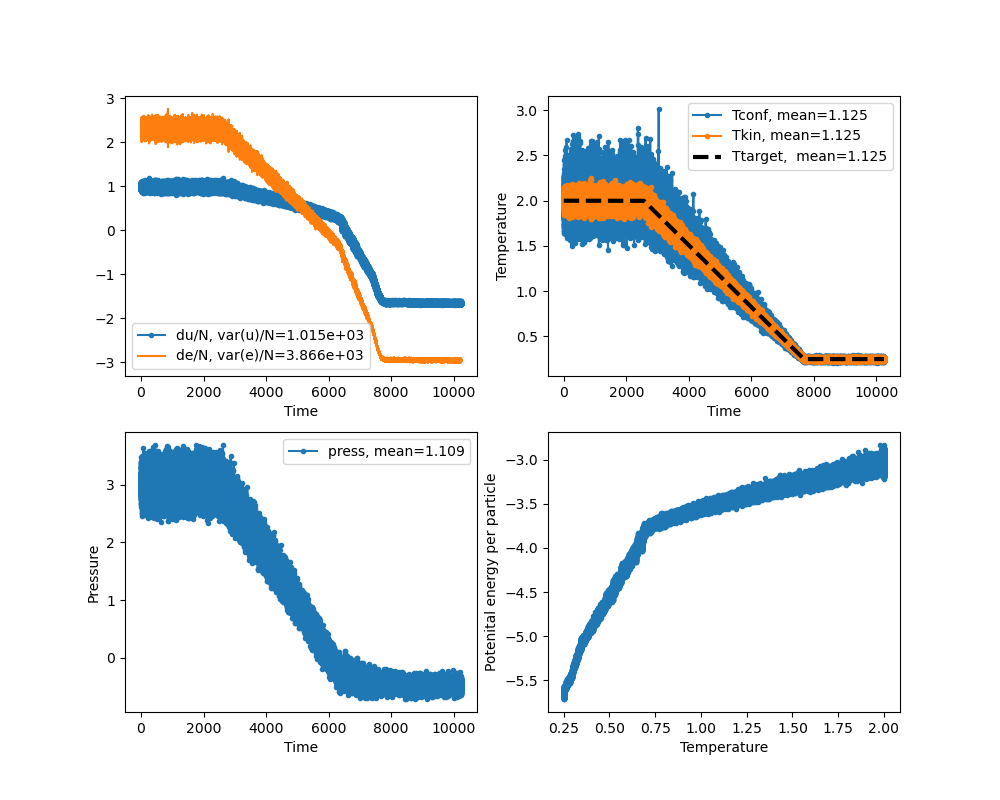

In [14]:
with open('Data/LJ_pdict.pkl', 'rb') as f:
    pdict = pickle.load(f)
df = pd.read_csv('Data/LJ_scalars.csv', index_col=False)
#print(df)
print(df.mean())
rp.plot_scalars(df, pdict['N'],  pdict['D'], figsize=(10,8), block=True)

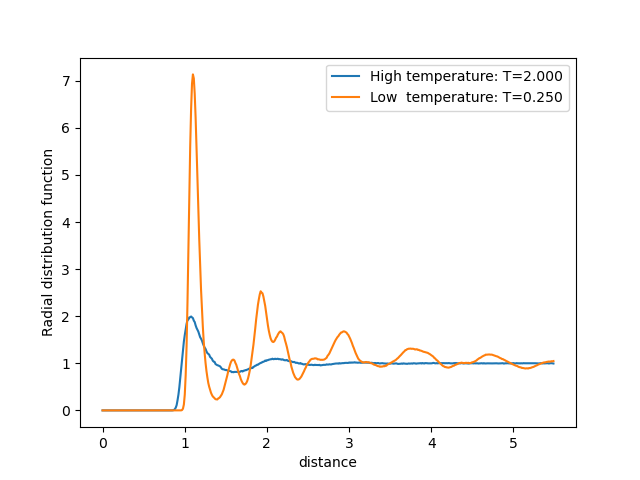

-rw-rw-r-- 1 tbs tbs 4.3M Jan 24 11:51 Data/LJ_rdf.dat


In [15]:
# WARNING old data !!!

with open('Data/LJ_pdict.pkl', 'rb') as f:
    pdict = pickle.load(f)

if pdict['rdf']:
    rdf = np.loadtxt('Data/LJ_rdf.dat')
    plt.figure()
    plt.plot(rdf[:,0], np.mean(rdf[:, 50: 250], axis=1), label=f'High temperature: T={Thigh:.3f}')
    plt.plot(rdf[:,0], np.mean(rdf[:,800:1000], axis=1), label=f'Low  temperature: T={Tlow:.3f}')
    plt.xlabel('distance')
    plt.ylabel('Radial distribution function')
    plt.legend()
    plt.show(block=False)

!ls -lh Data/LJ_rdf.dat

In [16]:
def calc_dynamics_(conf, conf_array, block0, conf_index0, block1, conf_index1, time_index, msd, m4d):
    dR =   conf_array[block1,conf_index1,0,:,:] - conf_array[block0,conf_index0,0,:,:]
    dR += (conf_array[block1,conf_index1,1,:,:] - conf_array[block0,conf_index0,1,:,:])*conf.simbox.data
    for i in range(np.max(conf.ptype) + 1):
        msd[time_index,i] += np.mean(np.sum(dR[conf.ptype==i,:]**2, axis=1))
        m4d[time_index,i] += np.mean(np.sum(dR[conf.ptype==i,:]**2, axis=1)**2)

    return msd, m4d

def calc_dynamics(conf, conf_array, dt):
    
    num_types = np.max(conf.ptype) + 1
    num_blocks, conf_per_block = conf_array.shape[0:2]
    extra_times = int(math.log2(num_blocks))
    total_times = conf_per_block-1 + extra_times
    count = np.zeros((total_times,1), dtype=np.int32)
    msd = np.zeros((total_times, num_types))
    m4d = np.zeros((total_times, num_types))
    
    times = dt*2**np.arange(total_times)
    
    for block in range(0, num_blocks):
        for i in range(conf_per_block-1):
            count[i] += 1
            calc_dynamics_(conf, conf_array, block, i+1, block, 0, i, msd, m4d)
            
    # Compute times longer than blocks
    for block in range(0, num_blocks):
        for i in range(extra_times):
            index = conf_per_block-1 + i 
            other_block = block + 2**(i+1)            
            if other_block < num_blocks:
                count[index] += 1
                calc_dynamics_(conf, conf_array, other_block, 0, block, 0, index, msd, m4d)
 
    msd /= count
    m4d /= count
    alpha2 = 3*m4d/(5*msd**2) - 1 
    return {'times':times, 'msd':msd, 'alpha2':alpha2, 'count':count}

In [17]:
%%time
if sim.storage=='memory':
    print(f'conf_blocks: {conf_blocks.shape}, {conf_blocks.nbytes/1024/1024:.2f} MB')
    dyn_high = calc_dynamics(c1, conf_blocks[ 50:250], dt) 
    dyn_low  = calc_dynamics(c1, conf_blocks[800:999], dt)

CPU times: user 2 µs, sys: 5 µs, total: 7 µs
Wall time: 11 µs


In [18]:
%%time
if sim.storage=='hdf5':
    with h5py.File(sim.filename+".h5", "r") as f:
        dyn_high = calc_dynamics(c1, f['block'][ 50:250], dt) # dt, c1.simbox.data should be read from file
        dyn_low  = calc_dynamics(c1, f['block'][800:999], dt) # dt, c1.simbox.data should be read from file

CPU times: user 925 ms, sys: 47.4 ms, total: 972 ms
Wall time: 969 ms


In [47]:
print(dyn_high.keys())
dyn_high['count'].T

dict_keys(['times', 'msd', 'alpha2', 'count'])


array([[200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 198,
        196, 192, 184, 168, 136,  72]], dtype=int32)

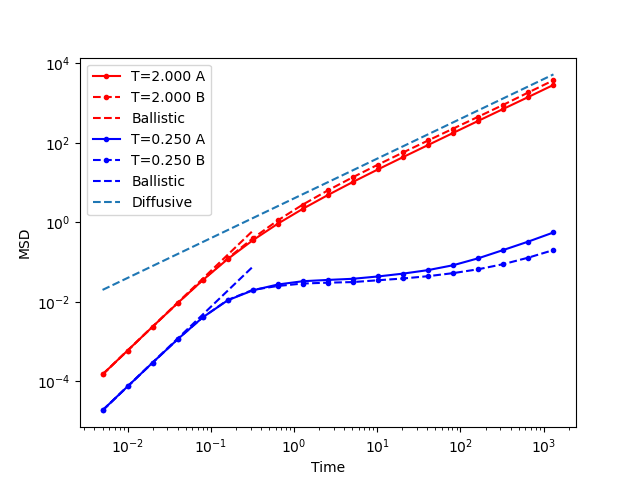

In [19]:
plt.figure()
num_types = dyn_high['msd'].shape[1]
plt.loglog(dyn_high['times'], dyn_high['msd'][:,0], 'r.-', label=f'T={Thigh:.3f} A')
if num_types>0:
    plt.loglog(dyn_high['times'], dyn_high['msd'][:,1], 'r.--', label=f'T={Thigh:.3f} B')
plt.loglog(dyn_high['times'][:7], 3*Thigh*dyn_high['times'][:7]**2, 'r--', label='Ballistic')
plt.loglog(dyn_low['times'], dyn_low['msd'][:,0], 'b.-', label=f'T={Tlow:.3f} A')
if num_types>0:
       plt.loglog(dyn_low['times'], dyn_low['msd'][:,1], 'b.--', label=f'T={Tlow:.3f} B') 
plt.loglog(dyn_low['times'][:7], 3*Tlow*dyn_low['times'][:7]**2, 'b--', label='Ballistic')
plt.loglog(dyn_low['times'], dyn_low['times']*4, '--', label='Diffusive')
plt.xlabel('Time')
plt.ylabel('MSD')
plt.legend()
plt.show()

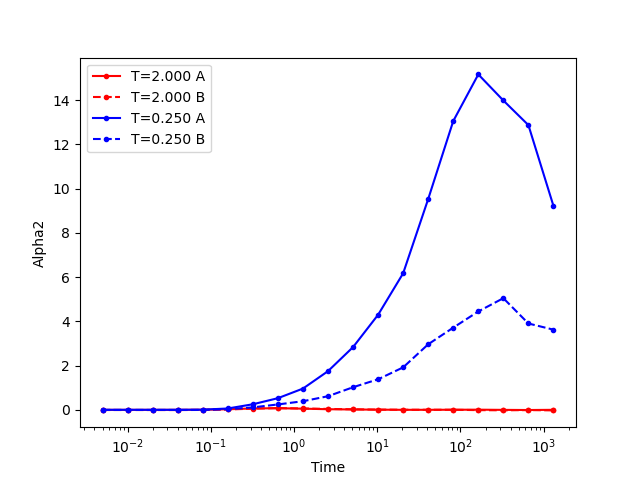

In [20]:
plt.figure()
plt.semilogx(dyn_high['times'], dyn_high['alpha2'][:,0], 'r.-', label=f'T={Thigh:.3f} A')
if num_types>0:
    plt.semilogx(dyn_high['times'], dyn_high['alpha2'][:,1], 'r.--', label=f'T={Thigh:.3f} B')
plt.semilogx(dyn_low['times'], dyn_low['alpha2'][:,0], 'b.-', label=f'T={Tlow:.3f} A') 
if num_types>0:
    plt.semilogx(dyn_low['times'], dyn_low['alpha2'][:,1], 'b.--', label=f'T={Tlow:.3f} B') 
plt.xlabel('Time')
plt.ylabel('Alpha2')
plt.legend()
plt.show()